In [1]:
import numpy as np
input_path = "full_numpy_bitmap_apple.npy"
data = np.load(input_path)
data = data / 255.0
data = np.reshape(data, (-1, 28, 28, 1))

(144722, 784)


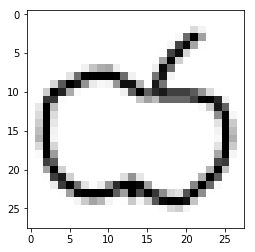

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(data[333,:,:,0], cmap="Greys")

In [3]:
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Conv2D, BatchNormalization, Dropout, Flatten
from keras.layers import Activation, Reshape, Conv2DTranspose, UpSampling2D
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [4]:
def discriminator():
    # 判别器输入为图片数据
    inputs = Input((28, 28, 1))
    conv1 = Conv2D(filters=64, 
                   kernel_size=(5, 5), 
                   strides=2, 
                   padding='same', 
                   activation='relu')(inputs)
    conv1 = Dropout(0.4)(conv1)
    conv2 = Conv2D(filters=128, 
                   kernel_size=(5, 5), 
                   strides=2, 
                   padding='same', 
                   activation='relu')(conv1)
    conv2 = Dropout(0.4)(conv2)
    conv3 = Conv2D(filters=256, 
                   kernel_size=(5, 5), 
                   strides=2, 
                   padding='same', 
                   activation='relu')(conv2)
    conv3 = Dropout(0.4)(conv3)
    conv4 = Conv2D(filters=512, 
                   kernel_size=(5, 5), 
                   strides=2, 
                   padding='same', 
                   activation='relu')(conv3)
    conv4 = Dropout(0.4)(conv4)
    flatten = Flatten()(conv4)
    # 对输入图片进行真假分类
    outputs = Dense(units=1, 
                    activation='sigmoid')(flatten)
    model = Model(inputs, outputs)
    # 将这个模型命名为判别器
    model.name = 'Discriminator'
    return model

In [5]:
# 加载判别器模型
discriminator = discriminator()
# 对判别器模型进行编译
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0008, 
                                        decay=6e-8, 
                                        clipvalue=1.0),
                      metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 256)         0         
__________

In [7]:
def generator():
    # 生成器的输入为长度为100的向量
    inputs = Input(shape=(100,))
    dense1 = Dense(7 * 7 * 64)(inputs)
    dense1 = BatchNormalization(momentum=0.9)(dense1)
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7, 7, 64))(dense1)
    dense1 = Dropout(0.4)(dense1)
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(filters=32, 
                            kernel_size=5, 
                            padding='same', 
                            activation=None)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(filters=16, 
                            kernel_size=5, 
                            padding='same', 
                            activation=None)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    conv3 = Conv2DTranspose(filters=8, 
                            kernel_size=5, 
                            padding='same', 
                            activation=None)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)
    # 生成器的输出为图片
    outputs = Conv2D(filters=1, 
                     kernel_size=5, 
                     padding='same', 
                     activation='sigmoid')(conv3)
    model = Model(inputs, outputs)
    # 将这个模型命名为生成器
    model.name = 'Generator'
    return model

In [8]:
generator = generator()

In [9]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              316736    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_1 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 64)        0         
__________

In [10]:
def images_generation():
    # 定义每次使用生成器生成图片的个数
    n_samples=16
    # 随机生成16个维度为100的向量
    random_samples = np.random.uniform(-1.0, 1.0, size=(n_samples, 100))
    # 使用生成器生成16张图片
    generated_imgs = generator.predict(random_samples)
    # 将这些生成出的图片进行可视化
    plt.figure(figsize=(5, 5))
    for i in range(n_samples):
        plt.subplot(4, 4, i+1)
        plt.imshow(generated_imgs[i, :, :, 0], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

In [11]:
def adversarial_network():
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(loss='binary_crossentropy',
                  optimizer=RMSprop(lr=0.0004, 
                                    decay=3e-8, 
                                    clipvalue=1.0),
                  metrics=['accuracy'])
    return model

In [12]:
model = adversarial_network()

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Generator (Model)            (None, 28, 28, 1)         396961    
_________________________________________________________________
Discriminator (Model)        (None, 1)                 4305409   
Total params: 4,702,370
Trainable params: 4,695,986
Non-trainable params: 6,384
_________________________________________________________________


In [14]:
def trainable(model, value):
    model.trainable = value
    for layer in model.layers:
        layer.trainable = value

Instructions for updating:
Use tf.cast instead.


D:\Anaconda3\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


============== 第0次训练 ==============


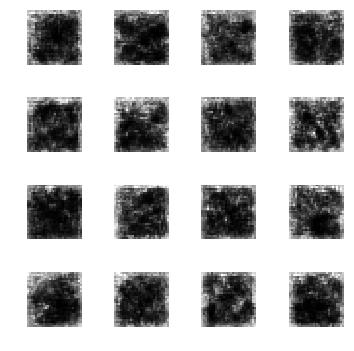

============== 第500次训练 ==============


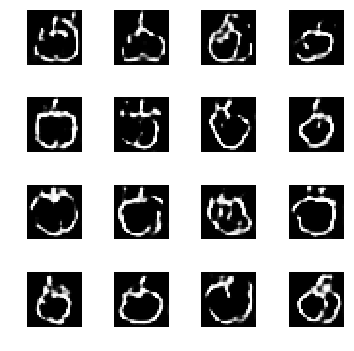

============== 第1000次训练 ==============


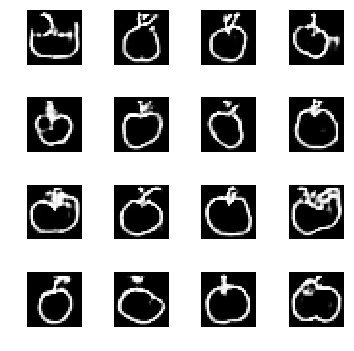

============== 第1500次训练 ==============


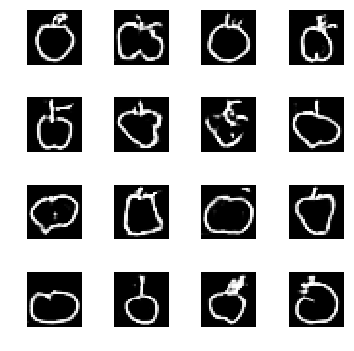

============== 第2000次训练 ==============


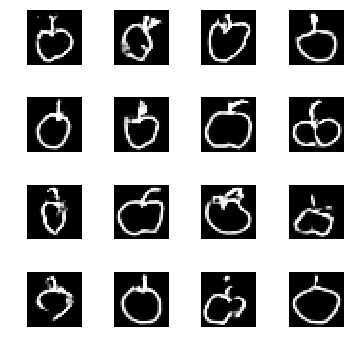

============== 第2500次训练 ==============


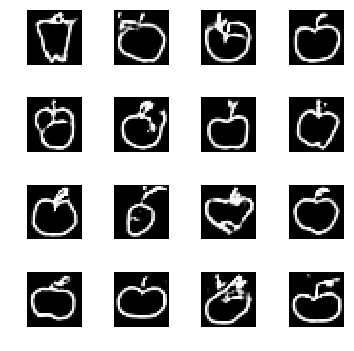

============== 第3000次训练 ==============


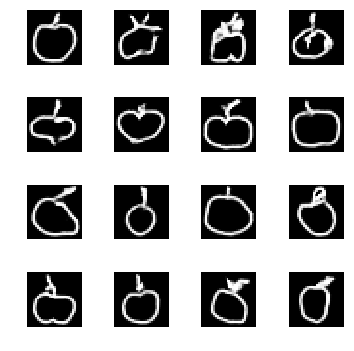

In [15]:
batch_size = 128
epochs = 3001
n_data = data.shape[0]
for i in range(epochs):
    # 从数据集中取出批量的真图片
    real_imgs = data[np.random.choice(n_data, batch_size, replace=False)]
    real_imgs = np.reshape(real_imgs, (batch_size, 28, 28, 1))
    # 使用生成器来生成批量假图片
    random_samples = np.random.uniform(-1.0, 1.0, size=(batch_size, 100))
    fake_imgs = generator.predict(random_samples)
    # 将真图片与假图片数据整合起来
    X = np.concatenate((real_imgs, fake_imgs))
    # 将真图片的标签全部指定为1
    y = np.ones((2*batch_size, 1))
    # 将假图片的标签全部指定为0
    y[batch_size:, :] = 0
    # 使用整合好的数据集来训练判别器
    trainable(discriminator, True)
    discriminator.train_on_batch(X, y)
    # 将本次的判别器训练好以后，接下来训练生成器
    # 将判别器模型的所有参数固定
    trainable(discriminator, False)
    # 准备批量的随机向量作为生成器的输入
    random_samples = np.random.uniform(-1.0, 1.0, size=(batch_size, 100))
    # 将所有生成器生成的图片标签值指定为1
    y = np.ones((batch_size, 1))
    # 使用刚刚处理好的数据集训练生成器
    model.train_on_batch(random_samples, y)
    # 每迭代训练500次以后，查看生成器模型生成图片的质量
    if i % 500 == 0:
        print(f"============== 第{i}次训练 ==============")
        images_generation()